# Fetch Data



### Set env variables

assumes that `SOCRATA_APP_TOKEN`, `SOCRATA_API_KEY_ID`, and `SOCRATA_API_KEY_SECRET` are set in `.env`

In [1]:
from dotenv import load_dotenv

load_dotenv()


True

### Load Packages

In [2]:
import os
import sys
import pdb
import censusdata
import pandas as pd
import geopandas as gpd

INGESTION_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.insert(0, INGESTION_PATH)

from ingestion import fetch
from ingestion import config

### Full Pull of Data
Takes about 48 minutes

In [3]:
# await fetch.fetch_all_data(save = True)

### Incremental Pull of Data

In [4]:
# await fetch.fetch_current_month(save = True)

### ACS Census Data

In [5]:
# =========================
# 1. Load the block group shapefile
# =========================
bg_shapefile = os.path.abspath(os.path.join(INGESTION_PATH, 'resources', "tl_2022_36_bg"))  # replace with your path
gdf_bg = gpd.read_file(bg_shapefile)

# Keep only NYC counties
nyc_counties = ["005", "047", "061", "081", "085"]  # Bronx, Kings, Manhattan, Queens, Richmond
gdf_bg = gdf_bg[gdf_bg['COUNTYFP'].isin(nyc_counties)].copy()

# Block group data is only available from 2012+ in ACS 5-year
# For 2010-2011, you'd need to use tract-level data or download from data.census.gov
years = list(range(2013, 2024))  # 2012–2023
acs_var = ['B01003_001E']  # total population

all_data = []

# Download data for each NYC county separately to avoid API issues
nyc_counties_list = ["005", "047", "061", "081", "085"]

for year in years:
    print(f"Downloading ACS 5-year data for {year}...")
    year_data = []
    
    for county in nyc_counties_list:
        try:
            print(f"  - County {county}...")
            data = censusdata.download(
                src='acs5',
                year=year,
                geo=censusdata.censusgeo([('state', '36'), ('county', county), ('block group', '*')]),
                var=acs_var
            )
            year_data.append(data)
        except Exception as e:
            print(f"    Error downloading county {county} for year {year}: {e}")
            continue
    
    if year_data:
        combined = pd.concat(year_data)
        combined = combined.reset_index()
        combined['year'] = year
        all_data.append(combined)

# Combine all years
df_pop = pd.concat(all_data, ignore_index=True)

# Parse GEOID from censusgeo index
def geo_to_geoid(geo):
    parts = geo.params()  # params is a method, not a property()
    return parts[0][1] + parts[1][1] + parts[2][1] + parts[3][1]

df_pop['GEOID'] = df_pop['index'].apply(geo_to_geoid)
df_pop.rename(columns={'B01003_001E': 'population'}, inplace=True)
df_pop = df_pop[['GEOID', 'population', 'year']]

# =========================

  - County 005...
  - County 047...
  - County 061...
  - County 081...
  - County 085...
  - County 005...
  - County 047...
  - County 061...
  - County 081...
  - County 085...
  - County 005...
  - County 047...
  - County 061...
  - County 081...
  - County 085...
  - County 005...
  - County 047...
  - County 061...
  - County 081...
  - County 085...
  - County 005...
  - County 047...
  - County 061...
  - County 081...
  - County 085...
  - County 005...
  - County 047...
  - County 061...
  - County 081...
  - County 085...
  - County 005...
  - County 047...
  - County 061...
  - County 081...
  - County 085...
  - County 005...
  - County 047...
  - County 061...
  - County 081...
  - County 085...
  - County 005...
  - County 047...
  - County 061...
  - County 081...
  - County 085...
  - County 005...
  - County 047...
  - County 061...
  - County 081...
  - County 085...
  - County 005...
  - County 047...
  - County 061...
  - County 081...
  - County 085...


In [6]:
# output_path = os.path.abspath(os.path.join(config.LOCAL_OUTPUT_DIR, "acs-population", "combined_population_data.csv"))
# df_pop.to_csv(output_path, index = False)

### Historical Weather Data

In [7]:
# NYC county FIPS codes
nyc_fips = ['36005', '36047', '36061', '36081', '36085']

# Years and months to loop over
years = range(2010, 2026)
months = range(1, 13)

# Base S3 URL
base_url = "https://noaa-nclimgrid-daily-pds.s3.amazonaws.com/EpiNOAA/v1-0-0/parquet/cty/YEAR={year}/STATUS=scaled/{yyyymm}.parquet"

# List to store all data
all_dfs = []

for year in years:
    for month in months:
        yyyymm = f"{year}{month:02d}"
        url = base_url.format(year=year, yyyymm=yyyymm)
        # Read Parquet file from S3
        try:
            df = pd.read_parquet(url)
            df_nyc = df[df["fips"].isin(nyc_fips)]
            df_nyc = df_nyc[["date", "fips", "tmax", "tmin", "tavg", "prcp"]]
        except Exception as e:
            print(f"Error loading {url}: {e}")
            continue
            
        all_dfs.append(df_nyc)
        print(f"Loaded {yyyymm}, rows: {len(df_nyc)}")

# Combine all months/years
nyc_data = pd.concat(all_dfs, ignore_index=True)

# Optional: add year/month columns
for i in ["tmax", "tmin", "tavg", "prcp"]:
    nyc_data[i] = nyc_data[i].astype(float)
nyc_data["date"] = pd.to_datetime(nyc_data["date"])
nyc_data["year"] = nyc_data["date"].dt.year
nyc_data["month"] = nyc_data["date"].dt.month

print(nyc_data.head())


Loaded 201001, rows: 155
Loaded 201002, rows: 155
Loaded 201003, rows: 155
Loaded 201004, rows: 155
Loaded 201005, rows: 155
Loaded 201006, rows: 155
Loaded 201007, rows: 155
Loaded 201008, rows: 155
Loaded 201009, rows: 155
Loaded 201010, rows: 155
Loaded 201011, rows: 155
Loaded 201012, rows: 155
Loaded 201101, rows: 155
Loaded 201102, rows: 155
Loaded 201103, rows: 155
Loaded 201104, rows: 155
Loaded 201105, rows: 155
Loaded 201106, rows: 155
Loaded 201107, rows: 155
Loaded 201108, rows: 155
Loaded 201109, rows: 155
Loaded 201110, rows: 155
Loaded 201111, rows: 155
Loaded 201112, rows: 155
Loaded 201201, rows: 155
Loaded 201202, rows: 155
Loaded 201203, rows: 155
Loaded 201204, rows: 155
Loaded 201205, rows: 155
Loaded 201206, rows: 155
Loaded 201207, rows: 155
Loaded 201208, rows: 155
Loaded 201209, rows: 155
Loaded 201210, rows: 155
Loaded 201211, rows: 155
Loaded 201212, rows: 155
Loaded 201301, rows: 155
Loaded 201302, rows: 155
Loaded 201303, rows: 155
Loaded 201304, rows: 155


In [ ]:
# output_path = os.path.abspath(os.path.join(config.LOCAL_OUTPUT_DIR, "noaa-nclimgrid-daily", "nyc_fips_weather_data.csv"))
# nyc_data.to_csv(output_path, index = False)

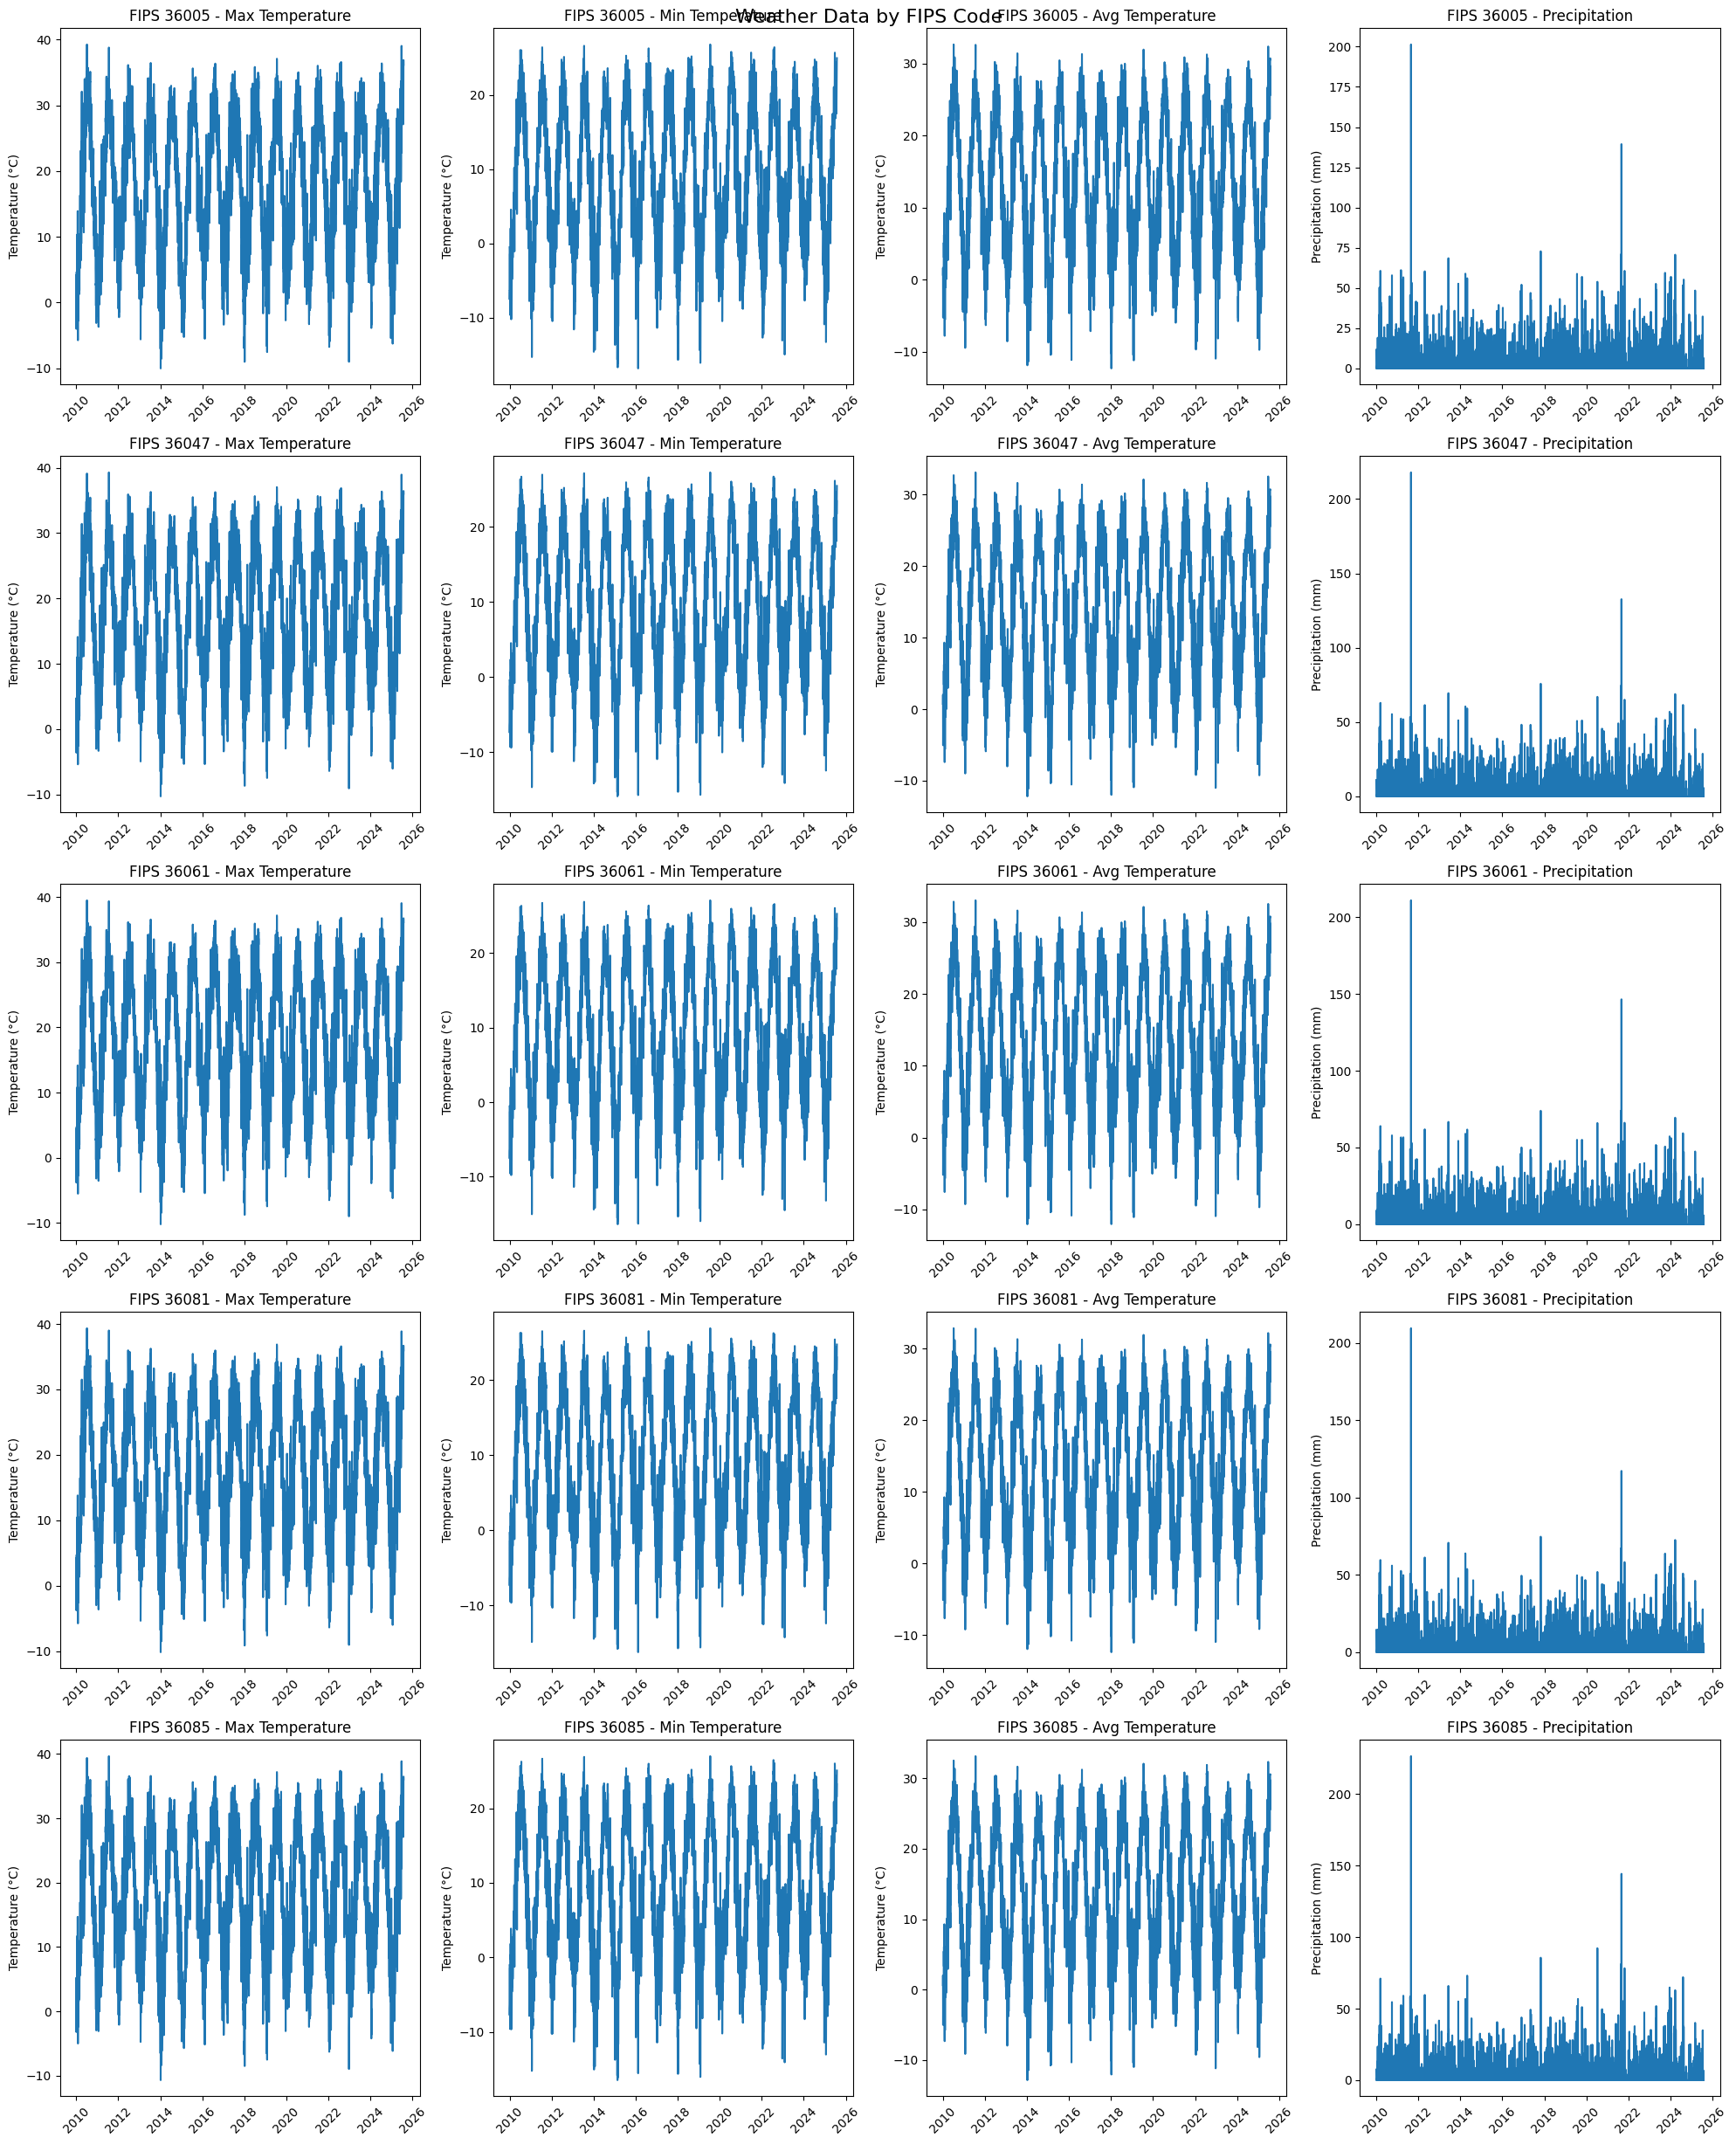

In [9]:
import matplotlib.pyplot as plt

# Convert columns to float
nyc_data['tmax'] = nyc_data['tmax'].astype(float)
nyc_data['tmin'] = nyc_data['tmin'].astype(float)
nyc_data['tavg'] = nyc_data['tavg'].astype(float)
nyc_data['prcp'] = nyc_data['prcp'].astype(float)

# Get unique FIPS codes
unique_fips = nyc_data['fips'].unique()

# Create subplots for each FIPS code
fig, axes = plt.subplots(len(unique_fips), 4, figsize=(20, 5*len(unique_fips)))
fig.suptitle('Weather Data by FIPS Code', fontsize=16)

for i, fips in enumerate(unique_fips):
    fips_data = nyc_data[nyc_data['fips'] == fips].sort_values('date')
    
    # Plot tmax
    axes[i, 0].plot(fips_data['date'], fips_data['tmax'])
    axes[i, 0].set_title(f'FIPS {fips} - Max Temperature')
    axes[i, 0].set_ylabel('Temperature (°C)')
    axes[i, 0].tick_params(axis='x', rotation=45)
    
    # Plot tmin
    axes[i, 1].plot(fips_data['date'], fips_data['tmin'])
    axes[i, 1].set_title(f'FIPS {fips} - Min Temperature')
    axes[i, 1].set_ylabel('Temperature (°C)')
    axes[i, 1].tick_params(axis='x', rotation=45)
    
    # Plot tavg
    axes[i, 2].plot(fips_data['date'], fips_data['tavg'])
    axes[i, 2].set_title(f'FIPS {fips} - Avg Temperature')
    axes[i, 2].set_ylabel('Temperature (°C)')
    axes[i, 2].tick_params(axis='x', rotation=45)
    
    # Plot prcp
    axes[i, 3].plot(fips_data['date'], fips_data['prcp'])
    axes[i, 3].set_title(f'FIPS {fips} - Precipitation')
    axes[i, 3].set_ylabel('Precipitation (mm)')
    axes[i, 3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
